In [4]:
PROC_TRAIN_DATA_PATH = "../../data/processed/preprocessed_train_data.pkl"
CLEANED_TEST_DATA_PATH = "../../data/interim/cleaned_test_data.pkl"


In [20]:
import pandas as pd
from dataclasses import dataclass

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline



# Read Data


In [6]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)
df_test = pd.read_pickle(CLEANED_TEST_DATA_PATH)
X_train, y_train = df_train.iloc[:, :-1], df_train["target"]
X_test, y_test = df_test.iloc[:, :-1], df_test["target"]


## Voting


In [ ]:
@dataclass
class ModelData:
    X_train: pd.DataFrame
    y_train: pd.DataFrame
    X_test: pd.DataFrame
    y_test: pd.DataFrame


model_data = ModelData(X_train, y_train, X_test, y_test)

print("Train set:  ", X_train.shape, y_train.shape)
print("Test set:   ", X_test.shape, y_test.shape)


In [ ]:
class Report:
    def __init__(self, estimator: BaseEstimator, model_data: ModelData):
        self.estimator = estimator
        self.model_data = model_data

    def calc_cross_val(self):
        acc = cross_val_score(
            self.estimator,
            self.model_data.X_train,
            self.model_data.y_train,
            cv=10,
            scoring="accuracy",
        ).mean()
        print("Cross Validation Score (mean):  {:3.4%}".format(acc))

    def calc_acc_val(self):
        print(
            "Train accuracy Score:  {:3.4%}".format(
                self.estimator.score(self.model_data.X_train, self.model_data.y_train)
            )
        )
        print(
            "Test accuracy Score:  {:3.4%}".format(
                self.estimator.score(self.model_data.X_test, self.model_data.y_test)
            )
        )

    def confusion_mat(self):
        print(
            classification_report(
                self.model_data.y_test, self.estimator.predict(self.model_data.X_test)
            )
        )

        _, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
        plot_confusion_matrix(
            self.estimator,
            self.model_data.X_test,
            self.model_data.y_test,
            ax=axs[0],
            cmap="Reds",
        )
        plot_confusion_matrix(
            self.estimator,
            self.model_data.X_train,
            self.model_data.y_train,
            ax=axs[1],
            cmap="Reds",
        )
        axs[0].set_title("Test")
        axs[1].set_title("Train")

    def roc_curve(self):
        try:
            _, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
            plot_roc_curve(
                self.estimator,
                self.model_data.X_train,
                self.model_data.y_train,
                ax=axs[0],
                color="r",
            )
            axs[0].plot([0, 1], [0, 1], linestyle="--")
            axs[0].set_xlabel("False Positive Rate")
            axs[0].set_ylabel("True Positive Rate")
            axs[0].set_title("Train")
            plot_roc_curve(
                self.estimator,
                self.model_data.X_test,
                self.model_data.y_test,
                ax=axs[1],
                color="r",
            )
            axs[1].plot([0, 1], [0, 1], linestyle="--")
            axs[1].set_xlabel("False Positive Rate")
            axs[1].set_ylabel("True Positive Rate")
            axs[1].set_title("Test")

        except ValueError as e:
            print("The ROC curve is not supported")

    def get_report(self):
        self.calc_cross_val()
        self.calc_acc_val()
        self.confusion_mat()
        self.roc_curve()


In [17]:
class VotingClassifierModel(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
    ):
        params = {
            "Random Forest": {
                "max_depth": 12,
                "max_features": 1,
                "n_estimators": 80,
            },
            "Gradient Boosting": {
                "learning_rate": 0.5,
                "max_depth": 3,
                "min_samples_leaf": 10,
                "random_state": 0,
            },
        }

        clfs = [
            ("Random Forest", RandomForestClassifier(**params["Random Forest"])),
            ("XGB2", GradientBoostingClassifier(**params["Gradient Boosting"])),
            ("Knn", KNeighborsClassifier()),
        ]

        self.model = VotingClassifier(clfs, n_jobs=-1)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X, y=None):
        return self.model.predict(X)

    # def get_report(self, model_data: ModelData):
    #     report: Report = Report(self.model, model_data)
    #     return report.get_report()


In [18]:
pipe = Pipeline(
    [
        (
            "reduce_dim",
            SelectFromModel(DecisionTreeClassifier(criterion="gini")),
        ),  # the reduce_dim stage is populated by the param_grid
        ("ros_resambling", RandomOverSampler()),
        # ("smote_resampling", SMOTE(random_state=42)),
        ("estimator", VotingClassifierModel()),
    ]
)


# ensemble_model = VotingClassifierModel()
# ensemble_model.fit(X_train, y_train)
# ensemble_model.get_report(model_data)

pipe.fit(X_train, y_train)


Pipeline(steps=[('reduce_dim',
                 SelectFromModel(estimator=DecisionTreeClassifier())),
                ('ros_resambling', RandomOverSampler()),
                ('estimator', VotingClassifierModel())])

In [21]:

y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.65      0.76      0.70        17
           1       0.00      0.00      0.00         6
           2       0.50      0.25      0.33         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.45        31
   macro avg       0.23      0.20      0.21        31
weighted avg       0.42      0.45      0.43        31



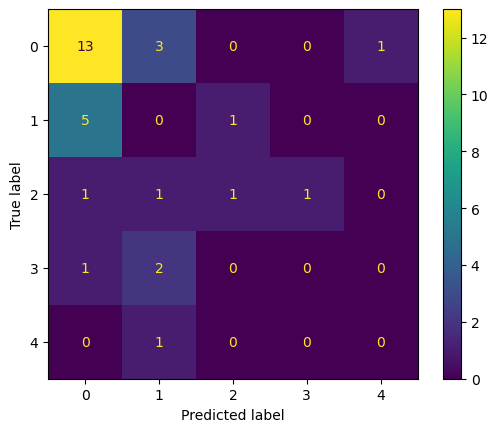

In [22]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
